# Notebook Dedicated to Contrust Hand-craft Deep Learning Models - Define by hand the architecture and hyperparms.

In [1]:
#import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout, BatchNormalization, Activation
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import shuffle
import optuna
from keras.backend import clear_session

In [2]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

In [3]:
image_dim = (10, 10)

#Directories
train_dataset_dir = "Data/High Stat/Elegant Data Frame Structure/train/df1_5500_10_(2.5_14)_(-5_7).csv"
test_dataset_dir = "Data/High Stat/Elegant Data Frame Structure/test/df2_test_5500_10_(2.5_14)_(-5_7).csv"

#Load in Pandas  DataFrame
df_train = shuffle(pd.read_csv(train_dataset_dir))
df_test = shuffle(pd.read_csv(test_dataset_dir))

In [4]:
df_train.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,...,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000
mean,43399.000000,0.103205,0.088559,0.097311,0.101131,0.101650,0.102036,0.102622,0.102890,0.103442,...,0.100280,0.100717,0.100868,0.101956,0.102550,0.103799,4.426912,4098.779480,0.500000,0.500000
std,25056.785175,0.255754,0.217296,0.196318,0.174071,0.154458,0.139249,0.126640,0.115322,0.105307,...,0.150967,0.136518,0.123935,0.113753,0.103857,0.095470,1.597788,1070.793561,0.500001,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500081,68.754494,0.000000,0.000000
25%,21699.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.029412,...,0.000000,0.000000,0.000000,0.022727,0.029412,0.034483,3.441121,3427.102417,0.000000,0.000000
50%,43399.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.047619,0.055556,0.062500,0.068966,...,0.031250,0.047619,0.055556,0.062500,0.068966,0.075000,3.875119,4336.404053,0.500000,0.500000
75%,65098.750000,0.000000,0.000000,0.111111,0.142857,0.142857,0.150000,0.150000,0.148148,0.148148,...,0.142857,0.142857,0.146341,0.147059,0.147059,0.147059,4.785668,4974.712646,1.000000,1.000000
max,86798.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.896552,0.816327,0.833333,...,1.000000,1.000000,0.909091,0.791667,0.840000,0.818182,13.546737,5499.991211,1.000000,1.000000


In [5]:
df_test.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,...,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000
mean,23260.000000,0.102381,0.086131,0.096609,0.100616,0.101405,0.101727,0.101638,0.101978,0.102806,...,0.100970,0.101846,0.102335,0.103169,0.103960,0.105062,4.420709,4100.394531,0.500000,0.500000
std,13429.528103,0.255092,0.214259,0.195932,0.174412,0.154686,0.139989,0.126693,0.115149,0.105888,...,0.151606,0.137405,0.124569,0.113891,0.104821,0.096305,1.587834,1070.269563,0.500003,0.500003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500030,106.154373,0.000000,0.000000
25%,11630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.028571,...,0.000000,0.000000,0.000000,0.023256,0.029851,0.035088,3.440157,3427.727112,0.000000,0.000000
50%,23260.000000,0.000000,0.000000,0.000000,0.000000,0.023533,0.047619,0.052632,0.061224,0.068182,...,0.032258,0.050000,0.055556,0.062500,0.071429,0.076923,3.873259,4335.557373,0.500000,0.500000
75%,34890.000000,0.000000,0.000000,0.111111,0.142857,0.142857,0.148148,0.148148,0.147059,0.147059,...,0.142857,0.148148,0.150000,0.150000,0.148649,0.148148,4.795290,4979.039795,1.000000,1.000000
max,46520.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.870968,0.814815,0.821429,...,1.000000,1.000000,0.857143,0.785714,0.766667,0.750000,13.663218,5499.998047,1.000000,1.000000


# Information Check on Norm($\Delta\alpha$) Images of 8B-$\nu_e$ and 208-Tl

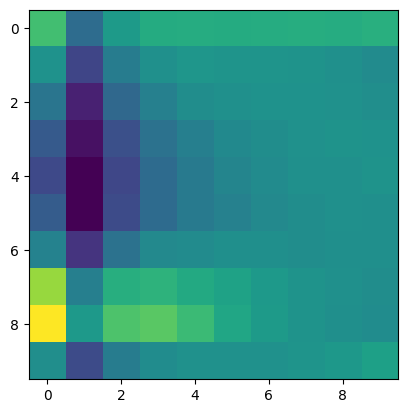

In [28]:
#Separate the solar_nue data from 208-Tl for train and test dataset
dataset_nue_train = (df_train[df_train['IsNu'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])
dataset_208tl_train = (df_train[df_train['IsTl'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])

dataset_nue_test = (df_train[df_train['IsNu'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])
dataset_208tl_test = (df_train[df_train['IsTl'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])

#Extract the pixels values of the normalized delta-alpha imaged and transform to np.array
pixels_nue_train = np.array(dataset_nue_train.filter(regex=pixel_pattern))
pixels_208tl_train = np.array(dataset_208tl_train.filter(regex=pixel_pattern))

pixels_nue_test = np.array(dataset_nue_test.filter(regex=pixel_pattern))
pixels_208tl_test = np.array(dataset_208tl_test.filter(regex=pixel_pattern))

#Recover the high-stat Delta-alpha distributions for solarnue and 208-Tl for train and test
DeltaAlpha_nue_train = np.sum(pixels_nue_train, axis = 0).reshape(10,10)
DeltaAlpha_208tl_train = np.sum(pixels_208tl_train, axis = 0).reshape(10,10)

DeltaAlpha_nue_test = np.sum(pixels_nue_test, axis = 0).reshape(10,10)
DeltaAlpha_208tl_test = np.sum(pixels_208tl_test, axis = 0).reshape(10,10)

#Plot: Just choose which image you want to observe
plt.imshow(DeltaAlpha_nue_test)
plt.show()

# Data Procesing

## Extract information and Define Energy Cuts

In [6]:
pixel_pattern = r'^pixel_\d+$'

energy_cut_train = 7
energy_cut_test = 7

### Extract Trainning Data

In [7]:
#Separate signal from background 
dataset_sig_train = (df_train[df_train['IsNu'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])
dataset_bkg_train = (df_train[df_train['IsTl'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])

#cut in solar energy
dataset_sig_train = (dataset_sig_train[dataset_sig_train['energy (MeV)'] <= energy_cut_train])

#Igualar cantidad de datos de neutrinos solares y de Tálio
N_solar_ev = dataset_sig_train.shape[0]
N_Tl_ev = dataset_bkg_train.shape[0]

if N_solar_ev > N_Tl_ev:
    dataset_sig_train = (dataset_sig_train.iloc[:N_Tl_ev, :]).reset_index().drop(columns = ['index'])

else:
    dataset_bkg_train = (dataset_bkg_train.iloc[:N_solar_ev, :].reset_index()).drop(columns = ['index'])
    
# Separate Features for signal and background: Useful for plots
df_pixel_sig_train = dataset_sig_train.filter(regex=pixel_pattern)
df_energy_sig_train = (dataset_sig_train[['energy (MeV)']])
df_radi_sig_train = (dataset_sig_train[['radius (mm)']])
df_label_sig_train = pd.DataFrame(dataset_sig_train, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_train = dataset_bkg_train.filter(regex=pixel_pattern)
df_energy_bkg_train = (dataset_bkg_train[['energy (MeV)']])
df_radi_bkg_train = (dataset_bkg_train[['radius (mm)']])
df_label_bkg_train = pd.DataFrame(dataset_bkg_train, columns = ['IsNu', 'IsTl'])

# Also save the join bkg+sig datasets and its labels to perform the standard scaler overall data
df_pixel_train = pd.concat([df_pixel_sig_train, df_pixel_bkg_train])
df_energy_train = pd.concat([df_energy_sig_train, df_energy_bkg_train])
df_radi_train = pd.concat([df_radi_sig_train, df_radi_bkg_train])
df_labels_train = pd.concat([df_label_sig_train, df_label_bkg_train])
labels_train = np.array(df_labels_train)

### Extract Test Data

In [8]:
equal_evs = True #Cambiar a True para Igualar eventos de 208-Tl y Solar Nu en test dataset!

#Separate signal from background 
dataset_sig_test = (df_test[df_test['IsNu'] == 1]).drop(columns=['Unnamed: 0'])
dataset_bkg_test = (df_test[df_test['IsTl'] == 1]).drop(columns=['Unnamed: 0'])

#cut in solar energy
dataset_sig_test = (dataset_sig_test[dataset_sig_test['energy (MeV)'] <= energy_cut_test])

if equal_evs:
    #Igualar cantidad de datos de neutrinos solares y de Tálio
    N_solar_ev = dataset_sig_test.shape[0]
    N_Tl_ev = dataset_bkg_test.shape[0]
    
    if N_solar_ev > N_Tl_ev:
        dataset_sig_test = (dataset_sig_test.iloc[:N_Tl_ev, :]).reset_index().drop(columns = ['index'])
    
    else:
        dataset_bkg_test = (dataset_bkg_test.iloc[:N_solar_ev, :].reset_index()).drop(columns = ['index'])

df_test_cut = shuffle(pd.concat([dataset_sig_test, dataset_bkg_test]))
        

#Separate Features
df_pixel_test = df_test_cut.filter(regex=pixel_pattern)
df_energy_test = df_test_cut[['energy (MeV)']]
df_radi_test = df_test_cut[['radius (mm)']]
df_labels_test = pd.DataFrame(df_test_cut, columns = ['IsNu', 'IsTl'])
labels_test = np.array(df_labels_test)

## Data Transformation

Choose a Data Transformation Option by running the corresponding cell

### Standard Scaler

In [82]:
# Train Transformation History
scaler_pixels_train = StandardScaler() 
scaler_energy_train = StandardScaler()
scaler_position_train = StandardScaler()

# Test Transformation History
scaler_pixels_test = StandardScaler() 
scaler_energy_test = StandardScaler() 
scaler_position_test = StandardScaler()

### MinMax Scaler

In [ ]:
# Train Transformation History
scaler_pixels_train = MinMaxScaler(feature_range=(-1, 1)) 
scaler_energy_train = MinMaxScaler(feature_range=(-1, 1))
scaler_position_train = MinMaxScaler(feature_range=(-1, 1))

# Test Transformation History
scaler_pixels_test = MinMaxScaler(feature_range=(-1, 1)) 
scaler_energy_test = MinMaxScaler(feature_range=(-1, 1)) 
scaler_position_test = MinMaxScaler(feature_range=(-1, 1))

### Pipeline MinMaxScaler(StandardScaler())

In [9]:
# Train Transformation History
scaler_pixels_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
scaler_energy_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
scaler_position_train = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
# Test Transformation History
scaler_pixels_test = Pipeline([('standardization', StandardScaler()),
                                ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
scaler_energy_test = Pipeline([('standardization', StandardScaler()),
                               ('minmax', MinMaxScaler(feature_range=(-1, 1)))])
scaler_position_test = Pipeline([('standardization', StandardScaler()),
                                 ('minmax', MinMaxScaler(feature_range=(-1, 1)))])

### Train Dataset Transformation

In [10]:
pixel_train_transf = scaler_pixels_train.fit_transform(df_pixel_train)
energy_train_transf = scaler_energy_train.fit_transform(df_energy_train).T[0]

#radial position to volume normalization Transformationm
vol = 5500**3 
position_train_transf_volnorm = (np.array(df_radi_train).T[0]**3)/vol

position_train_transf = scaler_position_train.fit_transform(position_train_transf_volnorm.reshape(-1, 1)).T[0]

### Test Dataset Transformation

In [11]:
pixel_test_transf = scaler_pixels_test.fit_transform(df_pixel_test)
energy_test_transf = scaler_energy_test.fit_transform(df_energy_test).T[0]

#radial position to volume normalization Transformationm
vol = 5500**3 
position_test_transf_volnorm = (np.array(df_radi_test).T[0]**3)/vol

position_test_transf = scaler_position_test.fit_transform(position_test_transf_volnorm.reshape(-1, 1)).T[0]

### Separation of sig from bkg in the Train and Test Datasets

In [16]:
#Separar sig from bkg and train from test
IsNu = np.array([1,0])
IsTl = np.array([0,1])

#Train: Separation sig from bkg
pixel_train_transf_sig = pixel_train_transf[np.array(df_labels_train == IsNu)[:,0]]
pixel_train_transf_bkg = pixel_train_transf[np.array(df_labels_train == IsTl)[:,0]]

energy_train_transf_sig = energy_train_transf[np.array(df_labels_train == IsNu)[:,0]]
energy_train_transf_bkg = energy_train_transf[np.array(df_labels_train == IsTl)[:,0]]

position_train_transf_sig = position_train_transf[np.array(df_labels_train == IsNu)[:,0]]
position_train_transf_bkg = position_train_transf[np.array(df_labels_train == IsTl)[:,0]]

#Test: Separation sig from bkg
pixel_test_transf_sig = pixel_test_transf[np.array(df_labels_test == IsNu)[:,0]]
pixel_test_transf_bkg = pixel_test_transf[np.array(df_labels_test == IsTl)[:,0]]

pixel_test_transf_sig = pixel_test_transf[np.array(df_labels_test == IsNu)[:,0]]
pixel_test_transf_bkg = pixel_test_transf[np.array(df_labels_test == IsTl)[:,0]]

energy_test_transf_sig = energy_test_transf[np.array(df_labels_test == IsNu)[:,0]]
energy_test_transf_bkg = energy_test_transf[np.array(df_labels_test == IsTl)[:,0]]

position_test_transf_sig = position_test_transf[np.array(df_labels_test == IsNu)[:,0]]
position_test_transf_bkg = position_test_transf[np.array(df_labels_test == IsTl)[:,0]]

labels_test_sig = labels_test[np.array(labels_test == IsNu)[:,0]]
labels_test_bkg = labels_test[np.array(labels_test == IsTl)[:,0]]

### Plots of the Transformed Features and Datasets

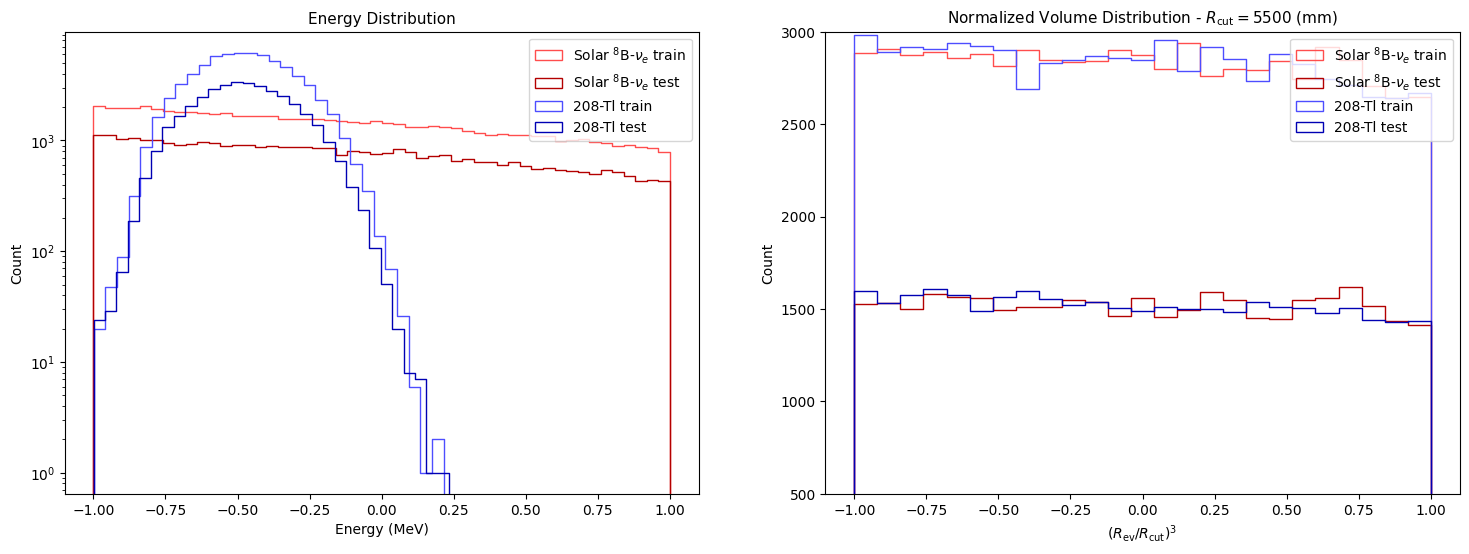

In [21]:
binwidth_en = 0.04
binwidth_rad = 0.08

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Plots
sn.histplot(energy_train_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(energy_test_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test')
sn.histplot(energy_train_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl train')
sn.histplot(energy_test_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[1], element = 'step', alpha = 0, label = '208-Tl test')

#Radial Plots
sn.histplot(position_train_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(position_test_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test')
sn.histplot(position_train_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl train')
sn.histplot(position_test_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[1], element = 'step', alpha = 0, label = '208-Tl test')

axes[0].set_xlabel('Energy (MeV)')
axes[0].legend(loc='upper right')
axes[0].set_title('Energy Distribution', fontsize = 11)
axes[0].set_yscale('log')

axes[1].set_xlabel(r'$(R_\text{ev}/R_\text{cut})^{3}$')
axes[1].legend(loc='upper right')
axes[1].set_title(r'Normalized Volume Distribution - $R_\text{cut} = $5500 (mm)', fontsize = 11)
axes[1].set_ylim(500, 3000)

#plt.savefig('figs/Optimized Models/10x10/Std_Rad_Norm_Vol and Std_Scaler_default Solar Energy/MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split/split_test_energy.png', format = 'png', bbox_inches = 'tight')
plt.show()

## For Last, Extract a Validation Dataset to be implemented in the Model

In [18]:
pixel_train1_transf, pixel_val_transf, \
energy_train1_transf, energy_val_transf, \
position_train1_transf, position_val_transf, \
labels_train1, labels_val = train_test_split(pixel_train_transf, energy_train_transf, position_train_transf,
                                            labels_train, test_size = 0.3,
                                            stratify = labels_train,
                                            random_state=42)

### Plots with Validation Dataset split

In [19]:
#Separar sig from bkg in new train1 and validation
IsNu = np.array([1,0])
IsTl = np.array([0,1])

sig_mask_train = np.all(labels_train1 == IsNu, axis=1)
bkg_mask_train = np.all(labels_train1 == IsTl, axis=1)

sig_mask_val = np.all(labels_val == IsNu, axis=1)
bkg_mask_val = np.all(labels_val == IsTl, axis=1)

#Train: Separation sig from bkg
pixel_train1_transf_sig = pixel_train1_transf[sig_mask_train]
pixel_train1_transf_bkg = pixel_train1_transf[bkg_mask_train]

energy_train1_transf_sig = energy_train1_transf[sig_mask_train]
energy_train1_transf_bkg = energy_train1_transf[bkg_mask_train]

position_train1_transf_sig = position_train1_transf[sig_mask_train]
position_train1_transf_bkg = position_train1_transf[bkg_mask_train]

#Validation: Separation sig from bkg
pixel_val_transf_sig = pixel_val_transf[sig_mask_val]
pixel_val_transf_bkg = pixel_val_transf[bkg_mask_val]

energy_val_transf_sig = energy_val_transf[sig_mask_val]
energy_val_transf_bkg = energy_val_transf[bkg_mask_val]

position_val_transf_sig = position_val_transf[sig_mask_val]
position_val_transf_bkg = position_val_transf[bkg_mask_val]

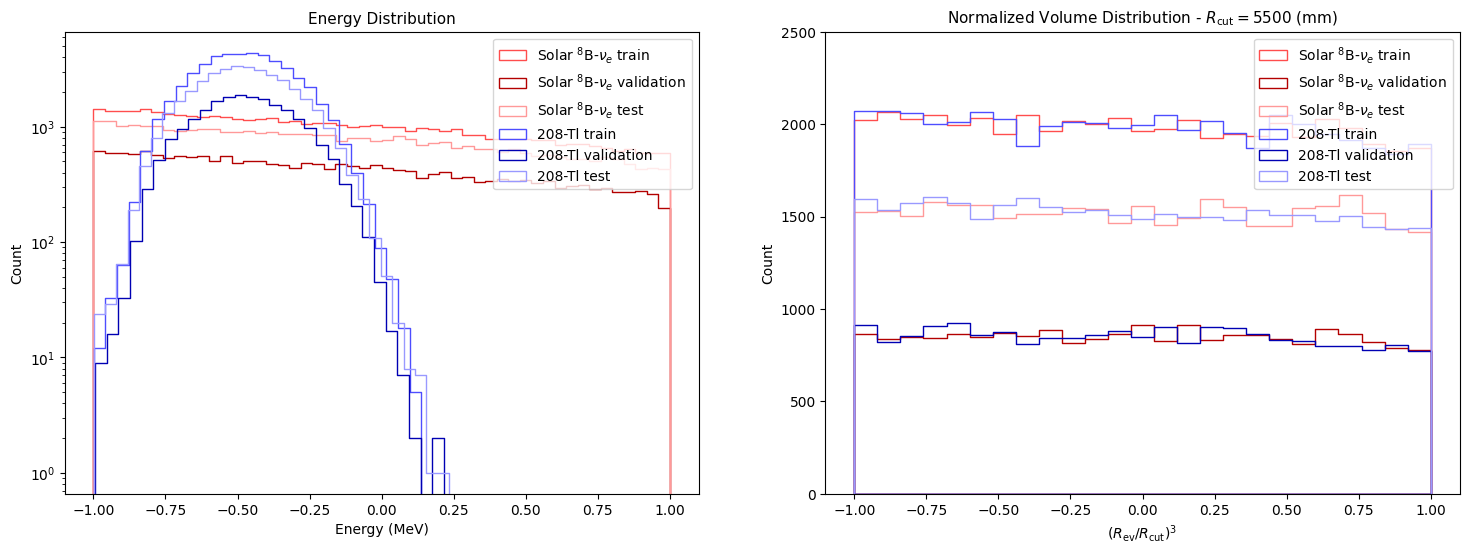

In [20]:
binwidth_en = 0.04
binwidth_rad = 0.08

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Plots
sn.histplot(energy_train1_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(energy_val_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ validation')
sn.histplot(energy_test_transf_sig, ax = axes[0], binwidth = binwidth_en, color = red_variants[2], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test')
sn.histplot(energy_train1_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl train')
sn.histplot(energy_val_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[1], element = 'step', alpha = 0, label = '208-Tl validation')
sn.histplot(energy_test_transf_bkg, ax = axes[0], binwidth = binwidth_en, color = blue_variants[2], element = 'step', alpha = 0, label = '208-Tl test')

#Radial Plots
sn.histplot(position_train1_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ train')
sn.histplot(position_val_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ validation')
sn.histplot(position_test_transf_sig, ax = axes[1], binwidth = binwidth_rad, color = red_variants[2], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test')
sn.histplot(position_train1_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl train')
sn.histplot(position_val_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[1], element = 'step', alpha = 0, label = '208-Tl validation')
sn.histplot(position_test_transf_bkg, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[2], element = 'step', alpha = 0, label = '208-Tl test')

axes[0].set_xlabel('Energy (MeV)')
axes[0].legend(loc='upper right')
axes[0].set_title('Energy Distribution', fontsize = 11)
axes[0].set_yscale('log')

axes[1].set_xlabel(r'$(R_\text{ev}/R_\text{cut})^{3}$')
axes[1].legend(loc='upper right')
axes[1].set_title(r'Normalized Volume Distribution - $R_\text{cut} = $5500 (mm)', fontsize = 11)
#axes[1].set_yscale('log')
axes[1].set_ylim(0, 2500)

#plt.savefig('figs/Optimized Models/10x10/Std_Rad_Norm_Vol and Std_Scaler_default Solar Energy/MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split/split_test_energy.png', format = 'png', bbox_inches = 'tight')
plt.show()

# Deep Learning Model Building

## Energy and Position Hidden Layered Model with BatchNorm

In [23]:
#Model Layers and Neuron Architecture ------------------------------------------------
input_image = Input(shape = (100,), name = 'image_input')
input_energy = Input(shape = (1,), name = 'energy_input')
input_position = Input(shape = (1,), name = 'position_input')

#Images hidden layers
image_ly = Dense(90, name = 'im_ly_1', use_bias = False)(input_image)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

image_ly = Dense(80, name = 'im_ly_2', use_bias = False)(image_ly)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

image_ly = Dense(60, name = 'im_ly_3', use_bias = False)(image_ly)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

image_ly = Dense(50, name = 'im_ly_4', use_bias = False)(image_ly)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

image_ly = Dense(30, name = 'im_ly_5', use_bias = False)(image_ly)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

#energy hidden layers
energy_ly = Dense(10, name = 'en_ly_1', use_bias = False)(input_energy)
energy_ly = BatchNormalization()(energy_ly)
energy_ly = Activation('gelu')(energy_ly)

energy_ly = Dense(5, name = 'en_ly_2', use_bias = False)(energy_ly)
energy_ly = BatchNormalization()(energy_ly)
energy_ly = Activation('gelu')(energy_ly)

energy_ly = Dense(2, name = 'en_ly_3', use_bias = False)(energy_ly)
energy_ly = BatchNormalization()(energy_ly)
energy_ly = Activation('gelu')(energy_ly)

#position hidden layers
position_ly = Dense(10, activation = 'gelu', name = 'pos_ly_1', use_bias = False)(input_position)
position_ly = BatchNormalization()(position_ly)
position_ly = Activation('gelu')(position_ly)

position_ly = Dense(5, name = 'pos_ly_2', use_bias = False)(position_ly)
position_ly = BatchNormalization()(position_ly)
position_ly = Activation('gelu')(position_ly)

position_ly = Dense(2, name = 'pos_ly_3', use_bias = False)(position_ly)
position_ly = BatchNormalization()(position_ly)
position_ly = Activation('gelu')(position_ly)

x = concatenate([image_ly, energy_ly, position_ly])

x = Dense(32, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(28, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(22, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dropout(rate = 0.5)(x)

x = Dense(20, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(15, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(10, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(5, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)
#-------------------------------------------------------------------------------------

model = Model(inputs = [input_image, input_energy, input_position], outputs = output_layer)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 9e-5),
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = ['AUC', 'accuracy'])


history = model.fit(x = {'image_input': pixel_train_transf, 'energy_input': energy_train_transf, 'position_input': position_train_transf}, 
                    y = {'nu_predict':labels_train}, 
                    epochs = 100, 
                    batch_size = 2000,
                    validation_split = 0.3,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 15, min_delta = 1e-2, monitor="val_AUC")],
                    shuffle = True)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - AUC: 0.5363 - accuracy: 0.4956 - loss: 0.7110 - val_AUC: 0.9999 - val_accuracy: 1.0000 - val_loss: 0.6806
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.5784 - accuracy: 0.5399 - loss: 0.6876 - val_AUC: 0.9894 - val_accuracy: 0.9931 - val_loss: 0.6760
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6221 - accuracy: 0.5791 - loss: 0.6671 - val_AUC: 0.9245 - val_accuracy: 0.9397 - val_loss: 0.6760
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6577 - accuracy: 0.6054 - loss: 0.6488 - val_AUC: 0.8154 - val_accuracy: 0.8334 - val_loss: 0.6784
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.6824 - accuracy: 0.6196 - loss: 0.6343 - val_AUC: 0.7305 - val_accuracy: 0.7588 - val_loss: 0.6841
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - AUC: 0.7003 - accuracy: 0.6273 - loss: 0.6225 - val_AUC: 0.6953 - val_accuracy: 0.7330 - val_loss: 0.6864
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1

## Energy-Position One Layer Model with BatchNorm

In [73]:
#Model Layers and Neuron Architecture ------------------------------------------------
input_image = Input(shape = (100,), name = 'image_input')
input_energy = Input(shape = (1,), name = 'energy_input')
input_position = Input(shape = (1,), name = 'position_input')

#Images hidden layers
image_ly = Dense(90, name = 'im_ly_1', use_bias = False)(input_image)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

image_ly = Dense(80, name = 'im_ly_2', use_bias = False)(image_ly)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

image_ly = Dense(60, name = 'im_ly_3', use_bias = False)(image_ly)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

image_ly = Dense(50, name = 'im_ly_4', use_bias = False)(image_ly)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

image_ly = Dense(30, name = 'im_ly_5', use_bias = False)(image_ly)
image_ly = BatchNormalization()(image_ly)
image_ly = Activation('gelu')(image_ly)

x = concatenate([image_ly, input_energy, input_position])

x = Dense(32, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(28, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(22, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dropout(rate = 0.5)(x)

x = Dense(20, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(15, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(10, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

x = Dense(5, use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('gelu')(x)

output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)
#-------------------------------------------------------------------------------------

model = Model(inputs = [input_image, input_energy, input_position], outputs = output_layer)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = ['AUC', 'accuracy'])


history = model.fit(x = {'image_input': pixel_train1_transf, 'energy_input': energy_train1_transf, 'position_input': position_train1_transf}, 
                    y = {'nu_predict':labels_train1}, 
                    epochs = 200, 
                    batch_size = 5000,
                    validation_data=([pixel_val_transf, energy_val_transf, position_val_transf], labels_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 15, min_delta = 1e-3, monitor="val_AUC")],
                    shuffle = True)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - AUC: 0.5256 - accuracy: 0.5242 - loss: 0.8081 - val_AUC: 0.5676 - val_accuracy: 0.5000 - val_loss: 0.6926
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.5396 - accuracy: 0.5343 - loss: 0.7851 - val_AUC: 0.5423 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.5505 - accuracy: 0.5458 - loss: 0.7723 - val_AUC: 0.5641 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - AUC: 0.5611 - accuracy: 0.5534 - loss: 0.7554 - val_AUC: 0.5509 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.5739 - accuracy: 0.5653 - loss: 0.7421 - val_AUC: 0.5719 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5800 - accuracy: 0.5696 - loss: 0.7374 - val_AUC: 0.5740 - val_accuracy: 0.5002 - val_loss: 0.6903
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1

## Energy-Position One Layer Model without BatchNorm

In [22]:
#Model Layers and Neuron Architecture ------------------------------------------------
input_image = Input(shape = (100,), name = 'image_input')
input_energy = Input(shape = (1,), name = 'energy_input')
input_position = Input(shape = (1,), name = 'position_input')

#Images hidden layers
image_ly = Dense(90, activation = 'gelu', name = 'im_ly_1')(input_image)
image_ly = Dense(80, activation = 'gelu', name = 'im_ly_2')(image_ly)
image_ly = Dense(60, activation = 'gelu', name = 'im_ly_3')(image_ly)
image_ly = Dense(50, activation = 'gelu', name = 'im_ly_4')(image_ly)
image_ly = Dense(30, activation = 'gelu', name = 'im_ly_5')(image_ly)

#energy_ly = Dense(1, activation = 'gelu')(input_energy)
#position_ly = Dense(1, activation = 'gelu')(input_position)

x = concatenate([image_ly, input_energy, input_position])

x = Dense(32, activation = 'gelu')(x)
x = Dense(28, activation = 'gelu')(x)
x = Dense(22, activation = 'gelu')(x)

x = Dropout(rate = 0.5)(x)

x = Dense(20, activation = 'gelu')(x)
x = Dense(15, activation = 'gelu')(x)
x = Dense(10, activation = 'gelu')(x)
x = Dense(5, activation = 'gelu')(x)

output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)
#-------------------------------------------------------------------------------------

model = Model(inputs = [input_image, input_energy, input_position], outputs = output_layer)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.BinaryCrossentropy(), 
              metrics = ['AUC', 'accuracy'])


history = model.fit(x = {'image_input': pixel_train1_transf, 'energy_input': energy_train1_transf, 'position_input': position_train1_transf}, 
                    y = {'nu_predict':labels_train1}, 
                    epochs = 200, 
                    batch_size = 1000,
                    validation_data=([pixel_val_transf, energy_val_transf, position_val_transf], labels_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 15, min_delta = 1e-3, monitor="val_AUC")],
                    shuffle = True)

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - AUC: 0.5006 - accuracy: 0.4829 - loss: 0.6932 - val_AUC: 0.5105 - val_accuracy: 0.6701 - val_loss: 0.6929
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.5268 - accuracy: 0.5588 - loss: 0.6921 - val_AUC: 0.5881 - val_accuracy: 0.5517 - val_loss: 0.6876
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.5711 - accuracy: 0.5708 - loss: 0.6871 - val_AUC: 0.6619 - val_accuracy: 0.6755 - val_loss: 0.6838
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.5987 - accuracy: 0.5981 - loss: 0.6830 - val_AUC: 0.6688 - val_accuracy: 0.6719 - val_loss: 0.6798
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.6298 - accuracy: 0.6323 - loss: 0.6788 - val_AUC: 0.6628 - val_accuracy: 0.6846 - val_loss: 0.6713
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.6489 - accuracy: 0.6577 - loss: 0.6734 - val_AUC: 0.6563 - val_accuracy: 0.6802 - val_loss: 0.6645
Epoch 7/200
100/100 ━━━━━━━━━━━━━

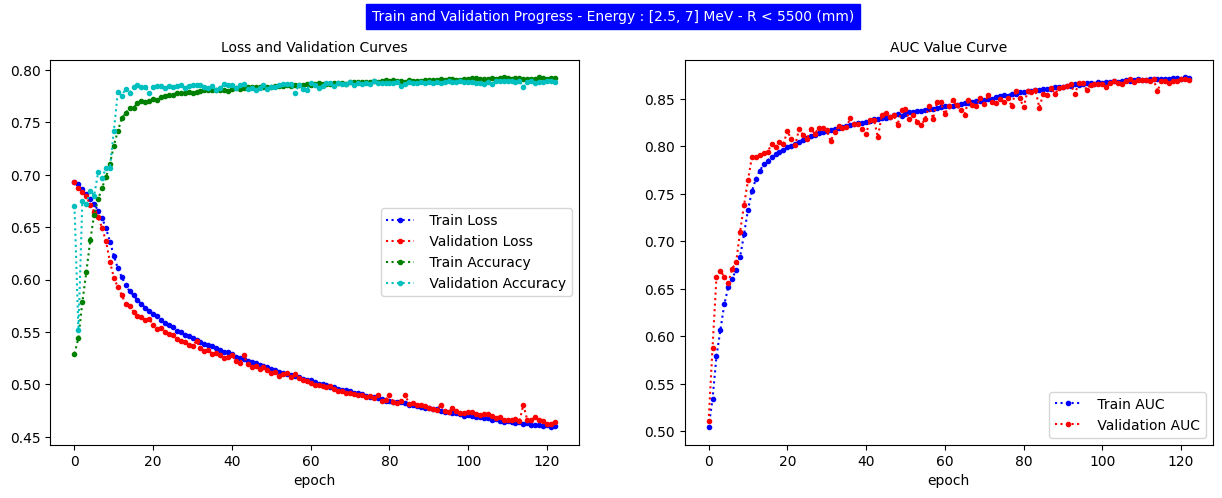

In [23]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(history.history['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(history.history['val_loss'], 'r:.', label = ' Validation Loss')
axes[0].plot(history.history['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(history.history['val_accuracy'], 'c:.', label = ' Validation Accuracy')
axes[1].plot(history.history['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(history.history['val_AUC'], 'r:.', label = ' Validation AUC')

axes[0].set_title('Loss and Validation Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

#axes[0].set_ylim(0, 1.2)
#axes[1].set_ylim(0, 1.05)

#axes[0].set_xlim(-2, len(history.history['loss']))
#axes[1].set_xlim(-2, len(history.history['loss']))

fig.suptitle(f'Train and Validation Progress - Energy : [2.5, {energy_cut_train}] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
plt.show()

# Model Predictions

In [24]:
X_sig_pred = model.predict([pixel_test_transf_sig, energy_test_transf_sig, position_test_transf_sig])
X_bkg_pred = model.predict([pixel_test_transf_bkg, energy_test_transf_bkg, position_test_transf_bkg])

1187/1187 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step


In [25]:
X_sig_pred

array([[0.86746037, 0.1129644 ],
       [0.8677062 , 0.11294282],
       [0.86768395, 0.11313409],
       ...,
       [0.8029148 , 0.18771815],
       [0.23342259, 0.77480966],
       [0.2535323 , 0.75186116]], dtype=float32)

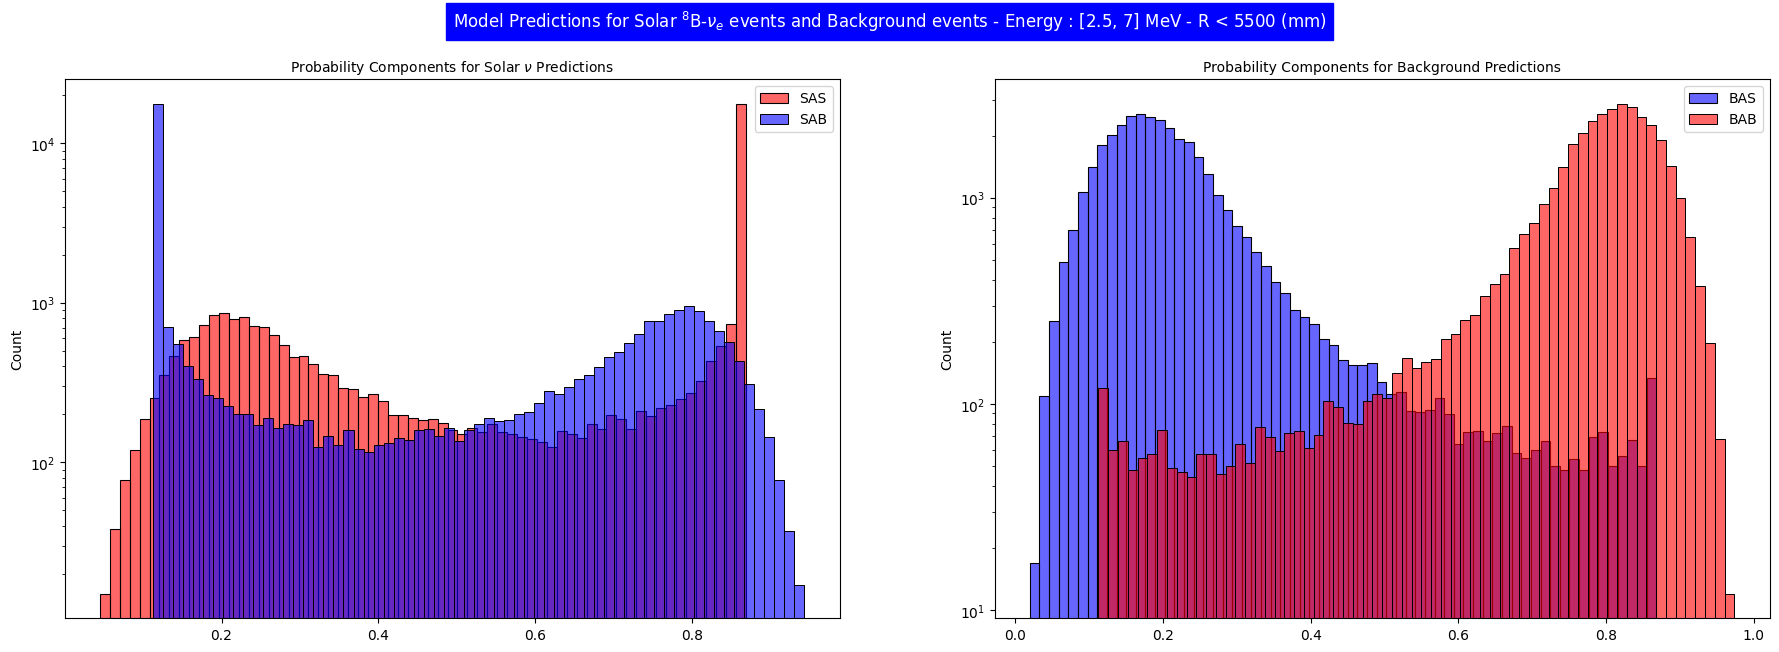

In [26]:
sn.reset_orig
bins = 65
fig, axes = plt.subplots(1, 2,  figsize=(22, 7))

sn.histplot(X_sig_pred[:,0], bins = bins, label = 'SAS', color = 'r', alpha = 0.6, ax = axes[0], log = True)
sn.histplot(X_sig_pred[:,1], bins = bins, label = 'SAB', color = 'b', alpha = 0.6, ax = axes[0])
sn.histplot(X_bkg_pred[:,0], bins = bins, label = 'BAS',color = 'b', alpha = 0.6, ax = axes[1], log = True)
sn.histplot(X_bkg_pred[:,1], bins = bins, label = 'BAB', color = 'r', alpha = 0.6, ax = axes[1])
axes[0].set_title('Probability Components for Solar $ν$ Predictions', fontsize = 10)
axes[1].set_title('Probability Components for Background Predictions', fontsize = 10)
axes[0].legend(loc = 'best')
axes[1].legend(loc = 'best')
plt.suptitle(f'Model Predictions for Solar $^8$B-$ν_e$ events and Background events - Energy : [2.5, {energy_cut_train}] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white')
plt.show()

## ROC Curve

In [27]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))              #Predicted
X_exp = np.concatenate((labels_test_sig, labels_test_bkg))     #Expected

# Classification for solar_nu events
fpr_sig, tpr_sig, thresholds_sig = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

# Classification for bkg events
fpr_bkg, tpr_bkg, thresholds_bkg = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

# Classification overall Model

fpr, tpr, thresholds = roc_curve(np.concatenate((X_exp[:,0], X_exp[:,1])), np.concatenate((X_pred[:,0], X_pred[:,1])))
auc_val = auc(fpr, tpr)

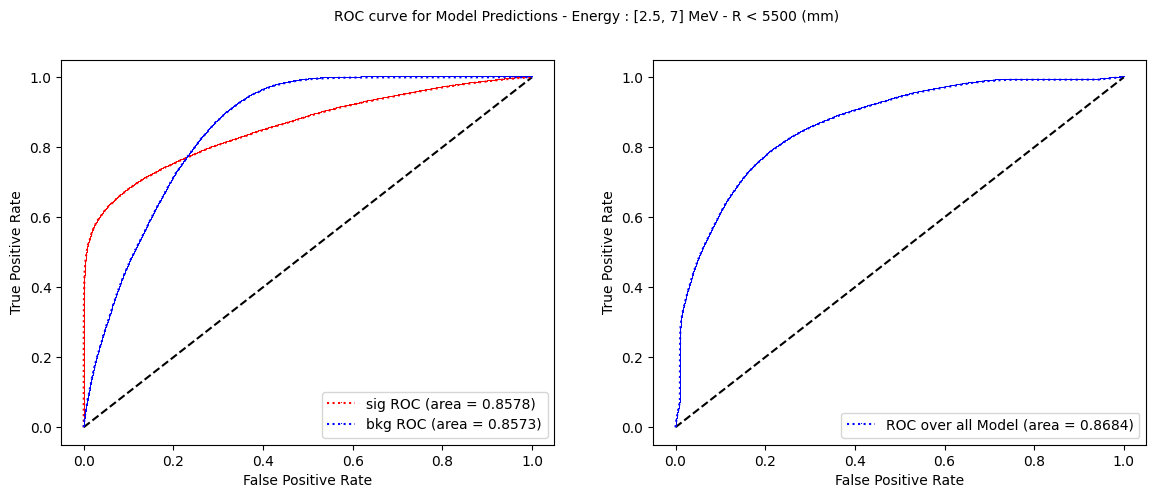

In [28]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))


axes[0].plot([0, 1], [0, 1], 'k--') #x=y
axes[0].plot(fpr_sig, tpr_sig, 'r:,', label = 'sig ROC (area = {:.4f})'.format(auc_sig))
axes[0].plot(fpr_bkg, tpr_bkg, 'b:,', label = 'bkg ROC (area = {:.4f})'.format(auc_bkg))

axes[1].plot([0, 1], [0, 1], 'k--') #x=y
axes[1].plot(fpr, tpr, 'b:,', label = 'ROC over all Model (area = {:.4f})'.format(auc_val))

axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')

axes[0].legend(loc = 'lower right')
axes[1].legend(loc = 'lower right')

fig.suptitle(f'ROC curve for Model Predictions - Energy : [2.5, {energy_cut_train}] MeV - R < 5500 (mm)', fontsize = 10)

#plt.savefig('figs/Optimized Models/10x10/ROC.png', format = 'png', bbox_inches = 'tight')
plt.show()